# Module 9 Lab - Model Evaluation - Solution

## Directions

1. Show all work/steps/calculations. If it is easier to write it out by hand, do so and submit a scanned PDF in addition to this notebook. Otherwise, generate a Markdown cell for each answer.
2. Submit your notebook (.ipynb).
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

In [1]:
import numpy as np
import numpy.random as random
import scipy.stats as stats
import patsy
import time

## Model Evaluation and Improvement

As we saw in both the Linear Regression and Logistic Regression modules, there is a Statistician's view of Model Evaluation (and perhaps, Improvement) and a Machine Learning view of Model Evaluation and Improvement.

We already are doing Bootstrap sampling to evaluate our Linear and Logistic Regressions, this is just as good as cross validation. For other models, we might need cross validation so we'll still need a little practice.

After that we're going to concentrate a bit more Model Improvement in this Lab.

*We need a lot of code from the previous modules. I'm going to put all the functions in a file called `regression.py` so that this notebook isn't completely messy. This isn't generally a great idea because it automatically makes the Notebook no longer self contained. I have been looking for ways to get around this but I haven't found any I like yet.*

*For your personal explorations, you probably will generate your own libraries for specific tasks: ETL, EDA, inference, visualization, etc.*

In [2]:
import regression

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**1\. Pick a Linear Regression model from the Module 7 Lab that you thought was particularly good at *prediction*.** Mean Squared Error (MSE) is the generally accepted performance metric for regression problems. Perform 3 rounds of 10 fold cross-validation on the model, calculating--in total--30 estimates of the MSE. Calculate the 90% Credible Intervale from the Non-Parametric Bayesian Boostrap estimate of the posterior distribution. Calculate the MSE for the true model. How well did you do?

*Instead of picking a model from before, we can just make a new one. We know that a model. An "interesting" model would be one with at least two variables and an $R^2$ in the range of about 0.8. We'll work with **standardized** values (mean scaled). This has no bearing on the outcome.*

In [4]:
random.seed( 13818349)

In [5]:
x1 = random.normal( 0.0, 15.0, 100)
x2 = random.normal( 0.0, 27.0, 100)
e = random.normal( 0.0, 75.0, 100)
y = 10.0 + 5.9 * x1 - 3.2 * x2 + e

data = pd.DataFrame({"x1": x1, "x2": x2, "y": y})

By now, we should have the mindset of EDA. We look first at variables individually and then at pairwise relationships. I don't expect to see anything *too* weird here because this is synthetic data. However, I expect at least the following:

1. $x_1$, $x_2$ and $y$ will all be approximately normally distributed.
2. $x_1$ and $x_2$ will have little or no correlation.
3. $x_1$ and $y$ as well as $x_2$ and $y$ will have some correlation.

In [6]:
import eda

First, I can look at summary statistics for $x_1$. Notice that I only look at $x_1$...not all the variables. I follow this up with some plots, both a histogram and a box plot with a data point overlay:

In [7]:
data["x1"].describe()

count    100.000000
mean      -2.008320
std       16.344829
min      -53.857163
25%      -13.172760
50%       -1.022625
75%        9.585931
max       47.473174
Name: x1, dtype: float64

As this is synthetic data, there isn't a lot to check here. Usually, I would want to examine how the various statistics relate to each other and what that might tell me about my data. Of course, as we learned in the Visualization and EDA modules, the key to EDA is Visualization.

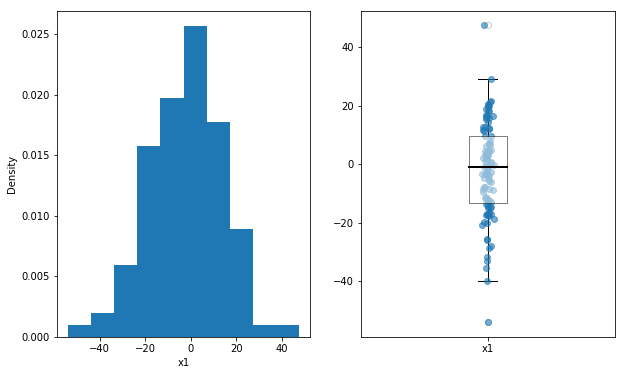

In [8]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist( data[ "x1"], normed=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "x1")

axes = figure.add_subplot(1, 2, 2)

patch = axes.boxplot( data[ "x1"], labels=["x1"], patch_artist=True)
eda.restyle_boxplot( patch)

x = np.random.normal(1, 0.01, size=len(data["x1"]))
axes.plot(x, data[ "x1"], 'o', alpha=0.6)

plt.show()
plt.close()

*Notice I have not put all the visualization code into a library. In a normal circumstance, I may need to fiddle with the size of the histogram bins. Automating everything makes me less inclined to actually explore the data.*

This looks like I would expect. Note that I follow the Visualization guidelines. There are no unnecessary colors and I do not use the saturated, default colors.

**I'm going to say something shocking. If you find ETL and EDA boring, you should probably consider a different field. Curiosity and patience are key qualities when doing data science.**

Of course, if we had an actual domain, it would be a bit more interesting. There are trade-offs. We want to be in control of the characteristics of our data when we're just learning. The algorithms are just little robots...they do what you tell them to do; they don't tell you if it was the *right* thing to do.

In [9]:
data["x2"].describe()

count    100.000000
mean       1.327994
std       29.994458
min      -71.509039
25%      -17.367195
50%       -3.009991
75%       20.983927
max       82.616931
Name: x2, dtype: float64

Again, it's interesting to see how skewed data sampled from a pure Normal distribution can be but that's about all we can do here.

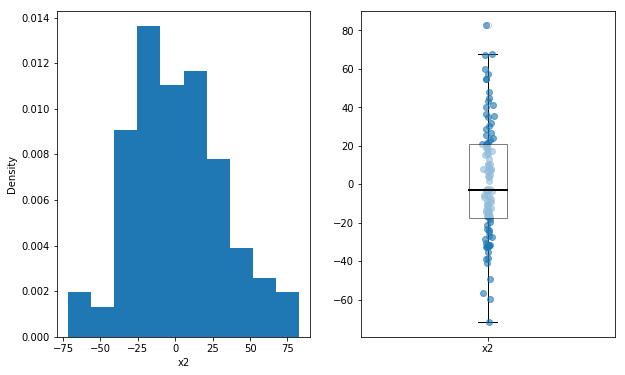

In [10]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist( data[ "x2"], normed=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "x2")

axes = figure.add_subplot(1, 2, 2)

patch = axes.boxplot( data[ "x2"], labels=["x2"], patch_artist=True)
eda.restyle_boxplot( patch)

x = np.random.normal(1, 0.01, size=len(data["x2"]))
axes.plot(x, data[ "x2"], 'o', alpha=0.6)

plt.show()
plt.close()

Finally, let's look at $y$:

In [11]:
data["y"].describe()

count    100.000000
mean      -4.639685
std      153.781231
min     -343.230745
25%     -114.410883
50%       13.497579
75%      100.328918
max      365.044894
Name: y, dtype: float64

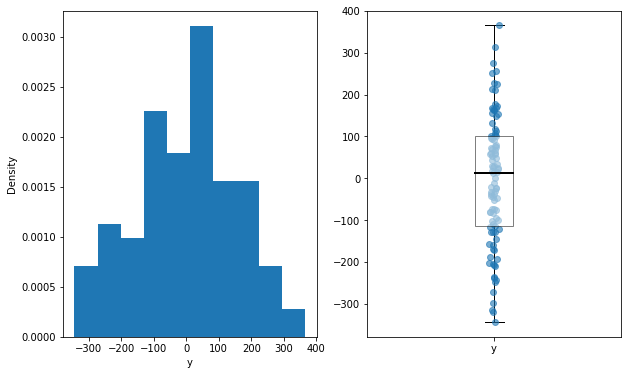

In [12]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 2, 1)
axes.hist( data[ "y"], normed=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "y")

axes = figure.add_subplot(1, 2, 2)

patch = axes.boxplot( data[ "y"], labels=["y"], patch_artist=True)
eda.restyle_boxplot( patch)

x = np.random.normal(1, 0.01, size=len(data["y"]))
axes.plot(x, data[ "y"], 'o', alpha=0.6)

plt.show()
plt.close()

Now let us move to our pairwise comparisons as they'll be a bit more interesting even with synthetic data. It can be a judgment call, but in the case where we have just three variables, we can look at the pairwise comparisons all at once (much like a lattice plot).

It would be nice if `matplotlib` had a default way of adding a regression line to a scatter plot but we can do it; we should probably have a library for this kind of plot.

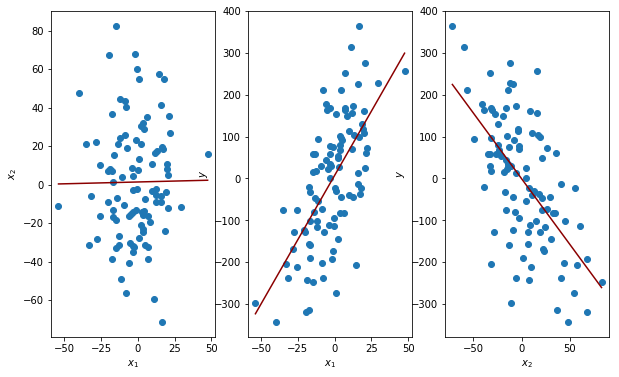

In [13]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 3, 1)
axes.scatter( data[ "x1"], data["x2"])
axes.set_ylabel( "Density")
axes.set_xlabel( r"$x_1$")
axes.set_ylabel( r"$x_2$")
m, b = np.polyfit(data["x1"], data["x2"], 1)
xs = np.linspace(np.min(data["x1"]), np.max(data["x1"]), 100)
axes.plot(xs, m*xs + b, color="darkred")

axes = figure.add_subplot(1, 3, 2)
axes.scatter( data[ "x1"], data["y"])
axes.set_ylabel( "Density")
axes.set_xlabel( r"$x_1$")
axes.set_ylabel( r"$y$")
m, b = np.polyfit(data["x1"], data["y"], 1)
xs = np.linspace(np.min(data["x1"]), np.max(data["x1"]), 100)
axes.plot(xs, m*xs + b, color="darkred")

axes = figure.add_subplot(1, 3, 3)
axes.scatter( data[ "x2"], data["y"])
axes.set_ylabel( "Density")
axes.set_xlabel( r"$x_2$")
axes.set_ylabel( r"$y$")
m, b = np.polyfit(data["x2"], data["y"], 1)
xs = np.linspace(np.min(data["x2"]), np.max(data["x2"]), 100)
axes.plot(xs, m*xs + b, color="darkred")

plt.show()
plt.close()

And we can look at the statistics (correlation coefficients) as well:

In [14]:
print( "x1 v x2")
print( "pearsons=", stats.pearsonr( data["x1"], data["x2"])[0])
print( "spearman=", stats.spearmanr( data["x1"], data["x2"])[0])
print( "-----")
print( "x1 v y")
print( "pearsons=", stats.pearsonr( data["x1"], data["y"])[0])
print( "spearman=", stats.spearmanr( data["x1"], data["y"])[0])
print( "-----")
print( "x2 v y")
print( "pearsons=", stats.pearsonr( data["x1"], data["y"])[0])
print( "spearman=", stats.spearmanr( data["x1"], data["y"])[0])

x1 v x2
pearsons= 0.010382736413
spearman= 0.0446324632463
-----
x1 v y
pearsons= 0.652889426125
spearman= 0.643420342034
-----
x2 v y
pearsons= 0.652889426125
spearman= 0.643420342034


This is largely as we might expect. $x_1$ and $x_2$ have very little correlation (they should have *none* theoretically). While both $x_1$ and $y$ as well as $x_2$ and $y$ have strong correlations.

*Putting all of these calculations in a single codecell is a judgment call. In general, it should be one result per cell. Here we have only 3 variables and a general theme of "correlation". I don't think I'd do this if we got much over, say, 5 variables.*

At this point, we should be confident that our model is:

```
y ~ x1 + x2
```

In [15]:
results = regression.lm( "y ~ x1 + x2", data=data)
regression.describe_fit( results)

regression:  y ~ x1 + x2
n:  100
----------
intercept:  12.0448833552
x1:  6.20338195591
x2:  -3.182390756
----------
sigma 67.4498771676
R^2 0.811508314752


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


The results we see here are a model built on the full data set. What we want from 10 fold cross validation is an estimation of our generalization error, how well our model will do on data it hasn't seen (wasn't used to create the model). We need two things:

1. a function that will do 10 fold cross validation $n$ times and generate $n$ values for some metric of our choosing.
2. an approximation of the posterior distribution of the metric.

What metric should we use? The traditional metric for regression is mean squared error. This is basically $\sigma^2$ so we can just use $\sigma$ and that will be fine (taking the square root doesn't do anything). Normally, we would have a sense of how good of an error rate $\sigma$ we need for our model.

Can we write a general fold cross-validation function? What would that entail?

1. create $k$ folds
2. train the model the training folds
3. test the model on the test fold.
4. use the desired evaluation metric.
5. repeat $n$ times
6. return the $n$ metrics.

So something like:

```
cross_validation( algorithm, formula, data, evaluate, fold_count, repetitions)
```

We start by defining our evaluation function for regression which will be "MSE" (really it's the square root of MSE or $\sigma$):

In [16]:
def mse( y, y_hat):
    return np.sqrt((1.0/len( y)) * np.sum((y - y_hat)**2))

We need a helper function that can take a list of `xs` and turn it into approximately `n` equal chunks:

In [17]:
def chunk( xs, n):
    k, m = divmod( len(xs), n)
    return [xs[i * k + min( i, m):(i + 1) * k + min(i + 1, m)] for i in range( n)]
#

We now have the pieces we need to make our cross validation function as defined above:

In [18]:
def cross_validation( algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list( range( len( data)))
    results = []
    for _ in range( repetitions):
        random.shuffle( indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm( formula, data=train_data)
            model = result["model"] # added in this version; not in Notebook.
            y, X = patsy.dmatrices( formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            y_hat = model.predict( X)
            metric = evaluate( y, y_hat)
            results.append( metric)
        #
    #
    return results

Let's run it for our current problem:

In [19]:
results = cross_validation( regression.lm, "y ~ x1 + x2", data, mse)
print( "mean=", np.mean( results))
print( "std =", np.std( results))

mean= 65.112591275
std = 12.8125269256


What we really need to do, like any other kind of inference we do, is get a feel for the variation of the generalization error of our model by estimating the posterior distribution of $\sigma$. We've already done this in Module 3.

In [20]:
def bootstrap_sample( data, f, n=100):
    result = []
    m = len( data)
    for _ in range( n):
        sample = np.random.choice( data, len(data), replace=True)
        r = f( sample)
        result.append( r)
    return np.array( result)

In [21]:
posterior = bootstrap_sample( results, np.mean, 1000)

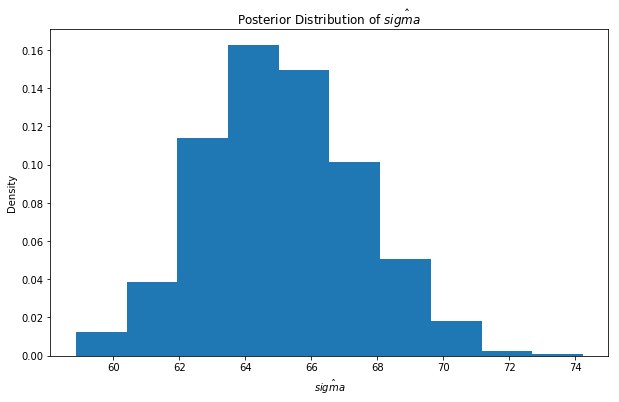

In [22]:
figure = plt.figure(figsize=(10, 6)) # first element is width, second is height.

axes = figure.add_subplot(1, 1, 1)

axes.hist( posterior, normed=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$\hat{sigma}$")
axes.set_title( "Posterior Distribution of $\hat{sigma}$")

plt.show()
plt.close()

In [23]:
stats.mstats.mquantiles( posterior, [0.05, 0.95])

array([ 61.46034294,  69.17510224])

In [24]:
stats.mstats.mquantiles( posterior, [0.025, 0.975])

array([ 60.57188138,  69.87502341])

So there are a lot of things we can do with the posterior distribution. 

I'm only doing the 95% credible interval because we lack domain knowledge (and I'm doing 95% instead of 90% here so I can compare later, see below). There is a 95% probability, given the data, that the $\sigma$--generalization error of our model--is between 63.8 and 70.8. Now, if we had a minimum error in mind...say 65, we could estimate the probability that the error is greater than 65. This is the advantage of the Bayesian approach to inference.

One question you might be asking yourself is how this relates to the Bootstrap approach we took during the Linear Regression module:

In [25]:
results = regression.bootstrap_lm( "y ~ x1 + x2", data)
regression.describe_bootstrap_fit( results)

regression:  y ~ x1 + x2
n:  100
----------
intercept:  12.0448833552 [1.3326539764644019, 27.86459640658021]
x1:  6.20338195591 [5.359606573375009, 7.137676140758869]
x2:  -3.182390756 [-3.6711558574574847, -2.840377416831148]
----------
sigma 67.4498771676 [ 57.0509674   73.13410829]
R^2 0.811508314752 [ 0.73300223  0.86636587]


The main difference is that when we used the Bootstrap fit, we used all the data to generate the model so that $\sigma$ is the error of the model on its training data. The "variance" comes from the resampling aspect of the Bootstrap. For cross validation, the estimate of $\sigma$ comes from the model on the *test* set.

Both of these are interesting views on the error of our model.

1. The bootstrap is better for credible intervals on the model itself (coefficients) in an explanatory model.
2. The cross validation is better for generalization error in a predictive model.

Finally, the question asks us to calculate the error for the true model. This is just the deterministic part compared to the actual y's:

In [26]:
y_hat = 10.0 + 5.9 * x1 - 3.2 * x2
mse( y, y_hat)

66.631847320222363

We did exceptionally well. This is most likely because the error we added was definitely normally distributed with constant variance. We shouldn't expect this to happen "in the wild".

Now that we've done all this work, the Logistic Regression should be easier...

**2\. Pick a Logistic Regression model from the Module 8 Lab that you thought was particularly good at *prediction*.** Although there are different metrics you can use for classification, because this data was made up, let's concentrate on error rate. Perform 3 rounds of 10 fold cross-validation on the model, calculating--in total--30 estimates of the error rate.  Calculate the 90% Credible Intervale from the Non-Parametric Bayesian Boostrap estimate of the posterior distribution. (This is a typo: Calculate the MSE for the true model. How well did you do?)

In [27]:
random.seed(764734234)

In [28]:
zs = 3.0 + 0.34 * x1 - 0.04 * x2
y = [1 if random.random() < regression.logistic( z) else 0 for z in zs]

In [29]:
data = pd.DataFrame({"x1": x1, "x2": x2, "y": y})

We don't need to revisit $x_1$ and $x_2$ since they are unchanged.

In [30]:
data["x1"].describe()

count    100.000000
mean      -2.008320
std       16.344829
min      -53.857163
25%      -13.172760
50%       -1.022625
75%        9.585931
max       47.473174
Name: x1, dtype: float64

In [31]:
data["x2"].describe()

count    100.000000
mean       1.327994
std       29.994458
min      -71.509039
25%      -17.367195
50%       -3.009991
75%       20.983927
max       82.616931
Name: x2, dtype: float64

We do need to look at our new--and categorical--$y$:

In [32]:
data["y"].value_counts()

1    67
0    33
Name: y, dtype: int64

As we discussed many times in the EDA module, it's not clear that many visualization techniques work very well for categorical variables and certainly not a binary one like $y$ so we'll stop here.

However, there are several *pairwise* comparisons that still make sense:

1. a box plot by $y$ for $x_1$ and $x_2$
2. a scatter plot color coded by $y$ (this is actually a 3-way plot).

Let's start by looking at the grouped data:

In [33]:
grouped = data.groupby( "y")

In [34]:
grouped["x1"].describe()

,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
0,33.0,-18.703936,11.299306,-53.857163,-25.339447,-16.939187,-12.076238,-0.209333
1,67.0,6.214894,11.437212,-16.830043,-1.424077,4.489022,15.056647,47.473174


This gives us the usual descriptive statistics by partitioned by each value of $y$. We can see that the average value of $x_1$ is lower for $y=0$ and higher for $y=1$.

As is often the case, we can get a real feel for the shape with a visualization:

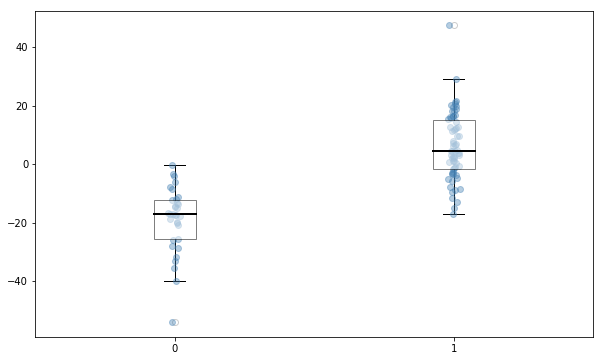

In [35]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)

y_values = pd.unique( data[ "y"].values)
group_data = [grouped[ "x1"].get_group( k) for k in y_values]
patch = axes.boxplot( group_data, labels=y_values, patch_artist=True)
eda.restyle_boxplot( patch)

for i, k in enumerate( y_values):
    grouped_data = grouped[ "x1"].get_group( k)
    x = np.random.normal(i + 1, 0.01, size=len(grouped_data))
    axes.plot(x, grouped_data, 'o', alpha=0.4, color="steelblue")
#
plt.show()
plt.close()

We can repeat this analysis for $x_2$:

In [36]:
grouped["x2"].describe()

,count,mean,std,min,25%,50%,75%,max
y,,,,,,,,
0,33.0,9.160319,30.279890,-40.781584,-10.906037,7.164234,22.192990,82.616931
1,67.0,-2.529719,29.311726,-71.509039,-22.287513,-7.340490,17.847979,67.738574


Here the relationship is reversed. The mean for $x_2$ is higher for $y=0$ and lower for $y=1$. These are the kinds of patterns you might expect to see if $x_i$ is a good predictor for a *categorical* variable like $y$.

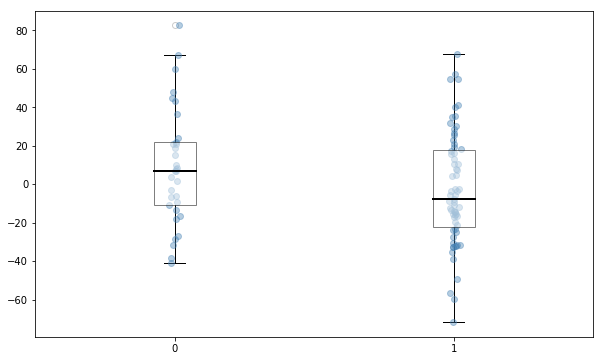

In [37]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)

y_values = pd.unique( data[ "y"].values)
group_data = [grouped[ "x2"].get_group( k) for k in y_values]
patch = axes.boxplot( group_data, labels=y_values, patch_artist=True)
eda.restyle_boxplot( patch)

for i, k in enumerate( y_values):
    grouped_data = grouped[ "x2"].get_group( k)
    x = np.random.normal(i + 1, 0.01, size=len(grouped_data))
    axes.plot(x, grouped_data, 'o', alpha=0.4, color="steelblue")
#
plt.show()
plt.close()

Notice, however, that the difference isn't quite as strong. If we wanted to, we could do statistical inference on these two to see if the difference in means is really believable.

Let's look at a scatter plot:

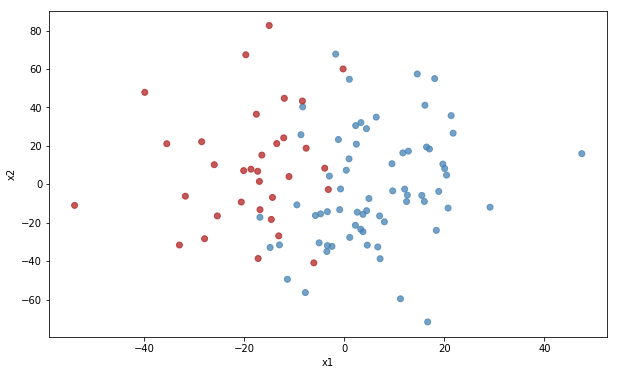

In [38]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

colors = ["firebrick" if y == 0 else "steelblue" for y in data["y"]]
axes.scatter( data[ "x1"], data[ "x2"], color=colors, alpha=0.75)
axes.set_xlabel( "x1")
axes.set_ylabel( "x2")

plt.show()
plt.close()

This view is interesting because it shows that the separation in classes is generally pretty clean but not completely noiseless.

Because we have all the code available, we only have to decide on a metric. Let's use error:

In [39]:
def error(ys, ys_hat):
    return np.mean([0 if y == y_hat else 1 for y, y_hat in zip( ys, ys_hat)])
#

In [40]:
results = cross_validation( regression.logm, "y ~ x1 + x2", data, error)
print( "mean=", np.mean( results))
print( "std =", np.std( results))

mean= 0.1
std = 0.0683130051064


So our error rate--measuring our generalization error--is about 12% on average. Let's do a Bootstrap estimate of the posterior distribution:

In [41]:
posterior = bootstrap_sample( results, np.mean, 1000)

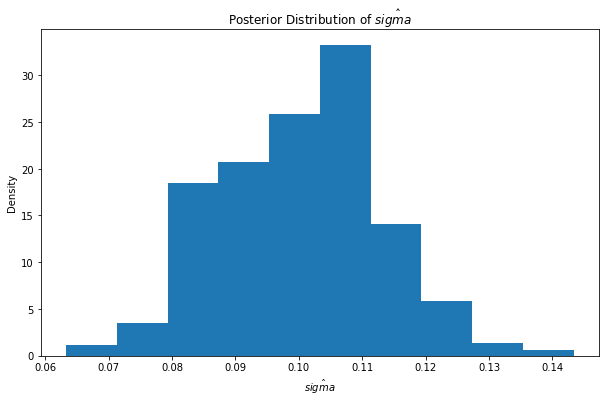

In [42]:
figure = plt.figure(figsize=(10, 6)) # first element is width, second is height.

axes = figure.add_subplot(1, 1, 1)

axes.hist( posterior, normed=True)
axes.set_ylabel( "Density")
axes.set_xlabel( "$\hat{sigma}$")
axes.set_title( "Posterior Distribution of $\hat{sigma}$")

plt.show()
plt.close()

In [43]:
stats.mstats.mquantiles( posterior, [0.05, 0.95])

array([ 0.08,  0.12])

Our 90% confidence interval shows that, given the data, our generalization error (as measured by the error rate), is about 8 to 16%.

Of course, in the case of classification, we may want to get more detailed and look at the confusion matrix, recall and precision. This is especially true if the costs associated with False Positives and False Negatives are not symmetric.

How do we test the real model? We can use the real formula and if the value is greater than 0.5, we call it "1" and if the value is less than 0.5, we call it "0":

In [44]:
ys_hat = [1 if 0.5 <= regression.logistic( z) else 0 for z in zs]

In [45]:
error( y, ys_hat)

0.10000000000000001

We would expect the real model to have a 10% error rate (it is probabilistic, after all).

## Model Improvement

As was discussed in the Lecture, our main method of evaluating whether a model can be improved is through the bias/variance tradeoff. This tradeoff can be evaluated in one of two ways: Learning Curves and Validation Curves.

*Learning Curves* concentrate on the perennial question: will getting more data improve this model?

*Validation Curves* concentrate on a related question: can more variables, regularization, and or transformations improve this model?

Note that these questions are always asked in a predictive sense, looking at the performance metric and its generalization to unseen data (test set). So, if we're to be good practitioners when working with real data, we want to *see* these things happen in controlled circumstances.

### Learning Curves

**1\. Basic Learning Curve.**

Create data for a Linear Regression model as we've done in previous Modules. You should have 3 to 5 variables but it doesn't have to be fancy or tricky. Generate 1000 observations. Plot Learning Curves for the Linear Regression using averaging over 10 fold cross validation. Make a special note of the $\epsilon$ you pick.

Do the Learning Curves indicate that getting more data would improve the model's predictive accuracy? If they do not, generate more data until they indicate you have enough data. How much did you need?

*So it might be difficult to find exactly the right combination of factors to learn all you can from this experiment. The basic idea/intention is that you could come up with a problem where you have more error than $\epsilon$ and getting more data will help. As we've seen above, it's really difficult to not estimate $\epsilon$ pretty accurately in synthetic data. Let's give it whirl.*

In [46]:
x1 = random.normal( 0.0, 100.0, 1000)
x2 = random.normal( 0.0, 50.0, 1000)
x3 = random.normal( 0.0, 75.0, 1000)
x4 = random.normal( 0.0, 250.0, 1000)
x5 = random.normal( 0.0, 25.0, 1000)
e = random.normal( 0.0, 32.0, 1000)
y = 10.0 + 5.0 * x1 - 4.5 * x2 + 1.2 * x3 - 7.5 * x4 + 3.9 * x5 + e

If this were a real problem, we would naturally do EDA which I'm going to skip for the sake of brevity.

Ideally, we could write a `learning_curve` function that used our previous `cross_validation` function but it isn't quite up to the task. We don't calculate the metric on both the training and test data and we don't calculate on percentages/portions of the training data. We can use it as a starting point, though.

Learning curves require incremental calculations of evaluation metrics for both the training and test data. Because we're tying into cross validation, we're also going to have mean values for each. Although it might be nice to be consistently Bayesian, in this particular case, I don't see a problem with just using the variance and praying to the Central Limit Theorem.

We'll get back two Lists. Each List will contain values and the values will be Tuples of the mean and variance. We also need to add an `increment` argument to the function:

In [47]:
from collections import defaultdict

As we calculate data through our repetitions and folds, we're going to want to keep track of a train result and a test result for each of the possible increments over all the partitions. Because increments could be 25%, 50%, 75%, 100% or 10%, 20%, ..., 100%, we should use a Dict for a *sparse* representation.

This is where some programming/software engineering experience comes in handy in data science. Sometimes the libraries don't do what you want them to do or there's a shiny new algorithm in the latest edition of some journal and you have to roll your own.

In [48]:
def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result
#
fold1 = data_collection()
fold1["train"][25].append( 0.73)
fold1["test"][25].append(0.79)
fold1["train"][25].append(0.52)
fold1["test"][25].append(0.69)
print( fold1)

{'train': defaultdict(<class 'list'>, {25: [0.73, 0.52]}), 'test': defaultdict(<class 'list'>, {25: [0.79, 0.69]})}


This allows us to insert new increment values automatically creating a list to hold all the metric values for each of training and test. We can then process this data later.

In [49]:
 def learning_curves( algorithm, formula, data, evaluate, fold_count=10, repetitions=3, increment=1):
    indices = list( range( len( data)))
    results = data_collection()
    for _ in range( repetitions):
        random.shuffle( indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range( increment, 100, increment)) + [100]: # ensures 100% is always picked.
                # the indices are already shuffled so we only need to take ever increasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                # we calculate the model
                result = algorithm( formula, data=train_data_chunk)
                model = result["model"] # added in this version; not in Notebook.
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices( formula, train_data_chunk, return_type="matrix")
                y_hat = model.predict( X)
                metric = evaluate( y, y_hat) # metric might not be provided by algorithm.
                results["train"][i].append( metric)
                # we calculate the results for the test data.
                y, X = patsy.dmatrices( formula, test_data, return_type="matrix")
                y_hat = model.predict( X)
                metric = evaluate( y, y_hat)
                results["test"][i].append( metric)
            #
        #
    # process results
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results
#

This function is a bit long with some code repetition. It's a prime candidate for refactoring and perhaps putting into a library. I've left it the way it is so you can study it a bit and perhaps find any errors.

Let's use it on our old data.

In [50]:
random.seed( 3472347)
results = learning_curves( regression.lm, "y ~ x1 + x2", data, mse, 10, 1, 5)

In order to generate our learning curves, instead of just show the one curve for training and test data, we're going to show the confidence interval around each curve based on 10 fold cross validation. The instructions say to use just one repetition but, of course, the more repetitions the better--subject to decreasing returns.

A `results_to_curves` function will take a specific type of results ("test" or "train") and take the data we just computed to estimate lower and upper bounds based on two (2) standard deviations from the mean. We could use the bootstrap but that seems like an awful lot of extra computation for little payoff. We can just invoke the Central Limit Theorem here.

One thing to consider would be a bootstrap estimation of the *difference* in the curves. This might actually be better than traditional learning curves. Let's see.

In [51]:
def results_to_curves( curve, results):
    all_statistics = results[ curve]
    keys = list( all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m, s = all_statistics[ k]
        mean.append( m)
        upper.append( m + 2 * s)
        lower.append( m - 2 * s)
    return keys, lower, mean, upper
#

And we can see what this looks like. I'm going to make this a function because we're going to be doing this a few times:

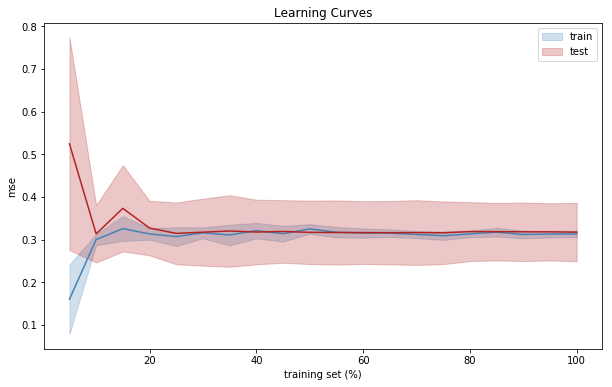

In [52]:
def plot_learning_curves( results):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)

    axes.plot( xs, train_mean, color="steelblue")
    axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25, label="train")
    axes.plot( xs, test_mean, color="firebrick")
    axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25, label="test")
    axes.legend()
    axes.set_xlabel( "training set (%)")
    axes.set_ylabel( "mse")
    axes.set_title("Learning Curves")

    plt.show()
    plt.close()
#
plot_learning_curves( results)

Well, this is what I wanted but is it useful? I'm not sure. I'm going to leave it for now. In general, it might be sufficient to just plot the means without the confidence bounds.

In order to make the problem a bit more interesting, we're going to start with a partial model $x_1$ and $x_2$ when we know that there are other variables.

In [53]:
data = pd.DataFrame({"x1": x1, "x2": x2, "x3": x3, "x4": x4, "x5": x5, "y": y})

I'm going to use the `%%timeit` magic here to see how long, on average, it takes for this to run.

In [54]:
%%timeit
random.seed( 7648394)
results = learning_curves( regression.lm, "y ~ x1 + x2", data, mse, 10, 1, 5)

2.34 s ± 24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


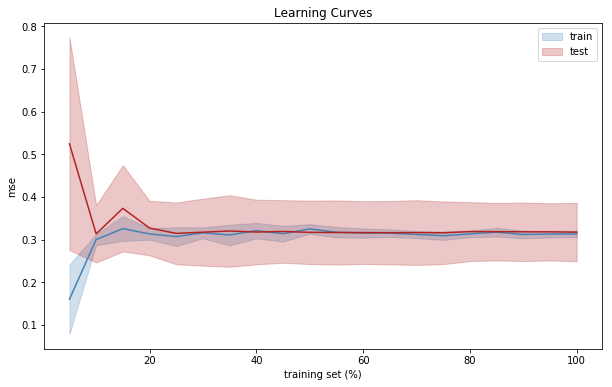

In [55]:
plot_learning_curves( results)

So this is why it's good to experiment with synthetic data. When you know the truth, and your tools say something about the data that seems to contradict the truth, you can learn how to interpret these situations in the real world. Algorithms are little robots that just do what they're told to do: "Garbage In, Garbage Out".

First, the curves seem to have their textbook shapes but they need not (try different random seeds to see what I mean).

Second, if we take variation into account, the variation on the test line is very large. This is to be expected to some degree (the test set is 1/9-th the size of the training set by the time we are using all of it).

Neverthless, we appear to be in a clearly "high bias" situation. Will adding more observations help if we have high bias? Nope. There's no sense in getting more observations. What about more inputs? Yes. More inputs (explanatory/predictor variables)--including variable transformations--*might* help...if we know of any.

Luckily, in this case, we do. Let's add in all the variables.

In [56]:
random.seed(47647434)
results = learning_curves( regression.lm, "y ~ x1 + x2 + x3 + x4 + x5", data, mse, 10, 1, 5)

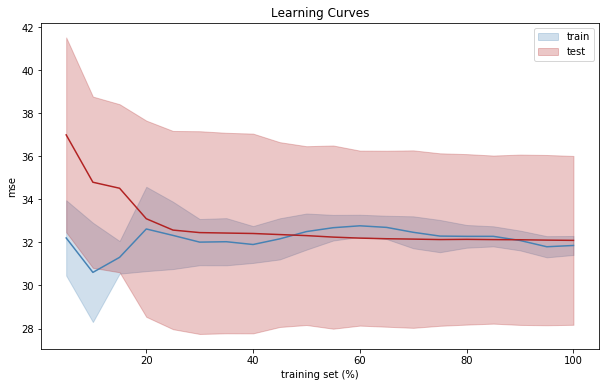

In [57]:
plot_learning_curves( results)

The important thing to note here is that we're still in a high bias situation but the error itself has decreased tremendously. We might think that getting more variables would help; and it might...except that we know that there are no more variables to get!

How do we know this in the real world? We don't really. We have to rely on domain knowledge and at some point, what is an acceptable level of error for the problem.

After we complete this step, we should go back to see what our generalization error is using cross validation and estimate the posterior distribution of the error (or whatever our evaluation metric is).

**2\. Increase your $\epsilon$, regenerate the data and re-plot the Learning Curves. Do this several times. Does increasing $\epsilon$ change the convergence of the Learning Curves or the absolute error at convergence?**

Let's double $\epsilon$ (well, really $\sigma$):

In [58]:
random.seed( 3774634)
e = random.normal( 0.0, 64.0, 1000)
y = 10.0 + 5.0 * x1 - 4.5 * x2 + 1.2 * x3 - 7.5 * x4 + 3.9 * x5 + e

In [59]:
data = pd.DataFrame({"x1": x1, "x2": x2, "x3": x3, "x4": x4, "x5": x5, "y": y})

In [60]:
random.seed(77838472)
results = learning_curves( regression.lm, "y ~ x1 + x2 + x3 + x4 + x5", data, mse, 10, 1, 5)

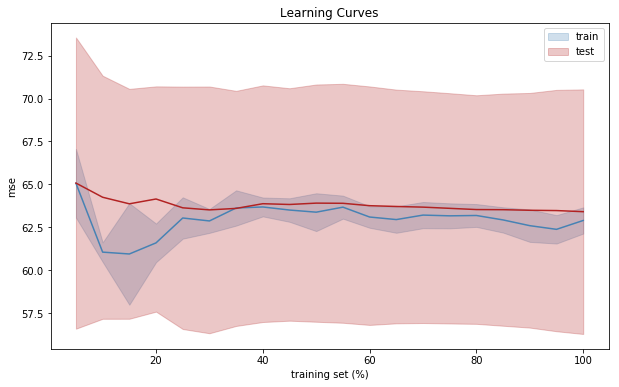

In [61]:
plot_learning_curves( results)

This doesn't really change anything except the absolute level of error we're able to achieve. We're still in a high bias situation.

**3\. Go back to your original $\epsilon$ and instead remove all your variables but one ($X_1$, for example). Now what happens to your Learning Curves? Do they still converge at a higher error rate or do they no longer converge?**

We already implicitly did this but the other way. It might be a better experiment to take a random 20% of the data and plot the learning curves and see if we can't find ourselves (finally) in a high *variance* situation.

In [62]:
e = random.normal( 0.0, 32.0, 1000)
y = 10.0 + 5.0 * x1 - 4.5 * x2 + 1.2 * x3 - 7.5 * x4 + 3.9 * x5 + e

In [63]:
data = pd.DataFrame({"x1": x1, "x2": x2, "x3": x3, "x4": x4, "x5": x5, "y": y})

In [64]:
small = data.iloc[list(range( 0, 200))]

In [65]:
random.seed(388475)
results = learning_curves( regression.lm, "y ~ x1 + x2 + x3 + x4 + x5", small, mse, 10, 1, 5)

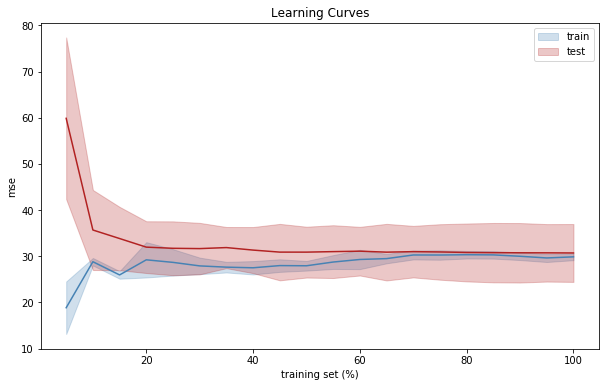

In [66]:
plot_learning_curves( results)

Well, that doesn't quite look like what we expected, right? With only 20% of the data, we thought we should be in a high variance situation but we seem to be right back in a high bias one.

One thing to note is that the error started out really, really high. Does this throw the scaling off? What if we re-write `learning_curves` to zoom in on the end values?

In [67]:
def plot_learning_curves( results, zoom=False):
    figure = plt.figure(figsize=(10,6))

    axes = figure.add_subplot(1, 1, 1)

    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)

    axes.plot( xs, train_mean, color="steelblue")
    axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25, label="train")
    axes.plot( xs, test_mean, color="firebrick")
    axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25, label="test")
    axes.legend()
    axes.set_xlabel( "training set (%)")
    axes.set_ylabel( "mse")
    axes.set_title("Learning Curves")

    if zoom:
        print( )
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))
    plt.show()
    plt.close()
#

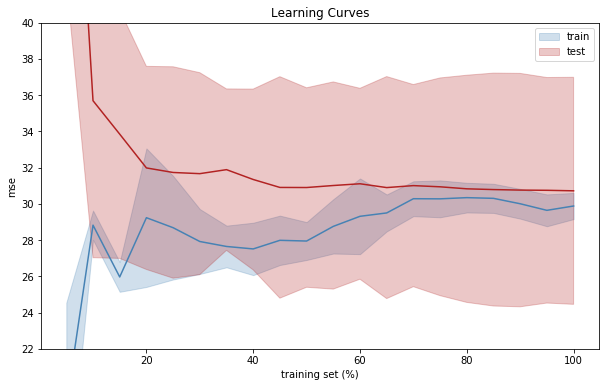

In [68]:
plot_learning_curves( results, zoom=True)

This is still somewhat unexpected. How might we account for this behavior?

When we do 10 fold cross validation with 1,000 observations, the training set is 900 observations and the test set is 100 observations. If we think that 200 observations is a "high bias" situation and would like to simulate that, we start with 200 observations. But this means that the test set is 20 observations, not 100. This is going to make the error lower than it was on the other Learning Curves.

There doesn't seem to be a good way to simulate the "high bias" situation of a particular set of learning curves without a lot of extra work.

Another thing we could do is when we compute learning curves, we could also compute a cross-validation score and plot that on our learning curves. If we don't end up in the 95% credible interval, something *might* be up.

At this point I would add that the confidence bounds I show on the learning curves would have been considered the "extra" that makes the difference between "B" and "A" work. I only asked for the curves themselves to be averaged from 10 fold cross validation. Adding the 95% credible interval would have been a good "extra" as well.

This is the kind of thing that shows me you understand what you're doing and not just engaging in copypasta.

## Validation Curves

**1\. Basic Validation Curve.**

This one should be pretty straight forward because we've been working with the canonical example. For these experiments, especially, it is probably best to be working with mean centered data. You can simply generate it that way. This will allow you to interpret the $beta$s more as weights/contributions than just scaling factors.

Create data for a Linear Regression model as we've done in previous Modules.  You should have 5 variables (inputs) but only 3 actual $X_i$. Using $D_i$ to indicate actual data, then $X_1 = D_1^1$, $X_2=D_1^n$, $X_3=D_1^{m}$ and $X_4=D_2$ and $X_5=D_3$.

$n$ and $m$ are to control different degrees of the polynomial and $m>n$. Really, you just want something like $D_1^1$, $D_1^2$, $D_1^5$, $D_2$, $D_3$ as your $X_1$, $X_2$, $X_3$, $X_4$, $X_5$.

Basically, you want to do validation curves for all your inputs starting with $X_1$, $X_4$, $X_5$ and then see if they indicate if $X_2$ and or $X_3$ are missing. What happens when the $beta$ is bigger on $X_1$ or the $beta$ is bigger on $X_4$? Does that make a difference? You should experiment with many variations.

*Our basic problem here is to look to see if we can learn from *validation curves* if higher degree polynomials are required in our regression. We have already seen how we might discover this by looking at residuals.*

In [69]:
d2 = x1**2
d5 = x1**5
y = 10.0 + 5.0 * x1 - 4.5 * x2 + 1.2 * x3 - 7.5 * d2 + 3.9 * d5 + e
data = pd.DataFrame({"x1": x1, "x2": x2, "x3": x3, "d2": d2, "d5": d5, "y": y})

Again, if this were your *only* problem, you would be doing EDA on all the variables. We'll forego that for now in the interest of space as this notebook is already getting very large.

Let us first do learning curves on the simple model:

In [70]:
random.seed(9812475)
results = learning_curves( regression.lm, "y ~ x1 + x2 + x3", data, mse, 10, 1, 5)

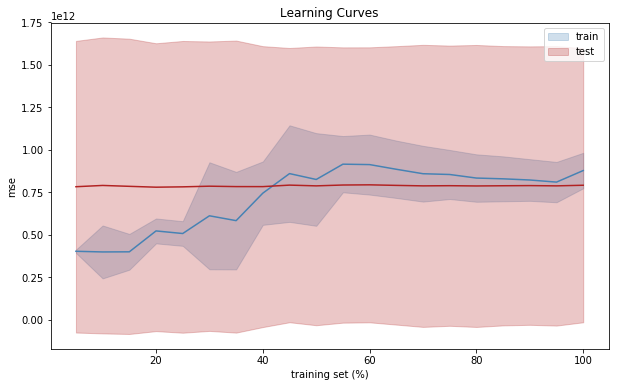

In [71]:
plot_learning_curves( results)

The first thing to note is that the error is *huge* (note the "1e12" on the y-axis). It's so large that it doesn't fluctuate much for the test set no matter how much of the training set we're using. We probably would have found out something was rotten in Schleswig-Holstein if we had just done cross-validation:

In [72]:
results = cross_validation( regression.lm, "y ~ x1 + x2 + x3", data, mse)
print( "mean=", np.mean( results))
print( "std =", np.std( results))

mean= 767022959255.0
std = 438473677793.0


This is just a stupidly horrible model. But what do we do? Maybe we shouldn't have been so quick to dismiss EDA...

In [73]:
def eda_for_numeric( variable, data):
    print( data[variable].describe())
    figure = plt.figure(figsize=(10, 6))

    axes = figure.add_subplot(1, 2, 1)
    axes.hist( data[ variable], normed=True)
    axes.set_ylabel( "Density")
    axes.set_xlabel( variable)

    axes = figure.add_subplot(1, 2, 2)

    patch = axes.boxplot( data[ variable], labels=[variable], patch_artist=True)
    eda.restyle_boxplot( patch)

    x = np.random.normal(1, 0.01, size=len(data[variable]))
    axes.plot(x, data[ variable], 'o', alpha=0.6)

    plt.show()
    plt.close()
#

count    1000.000000
mean        6.733494
std       100.379992
min      -318.008941
25%       -58.219132
50%         4.760868
75%        75.609168
max       332.507438
Name: x1, dtype: float64


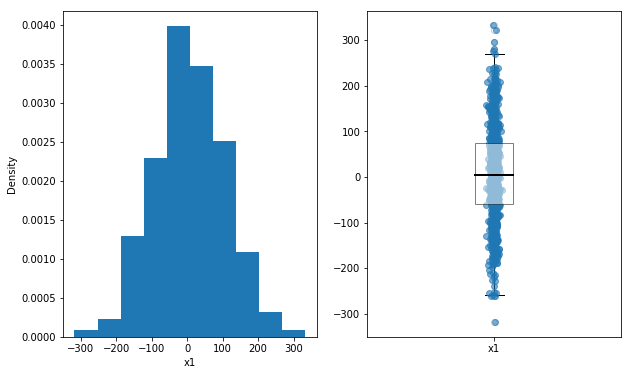

In [74]:
eda_for_numeric( "x1", data)

$x_1$ was made a lot bigger in our 2nd problem $N(0, 100)$ so the values are not outside the realm of reason.

count    1000.000000
mean        1.899905
std        51.326492
min      -164.234049
25%       -32.855603
50%         2.228759
75%        37.028359
max       165.993559
Name: x2, dtype: float64


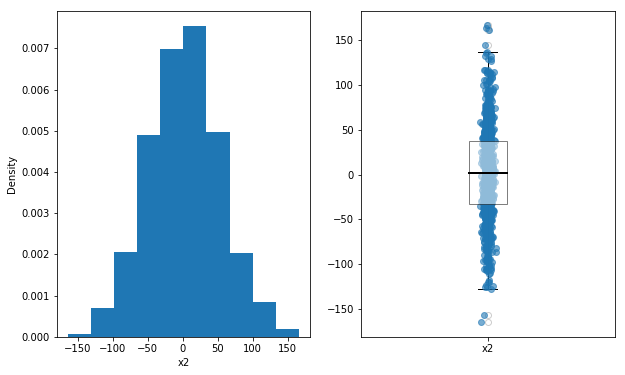

In [75]:
eda_for_numeric( "x2", data)

The same is true for $x_2$ above and $x_3$ below.

count    1000.000000
mean       -0.701767
std        75.433224
min      -254.819130
25%       -53.649946
50%         1.948895
75%        49.202015
max       268.211841
Name: x3, dtype: float64


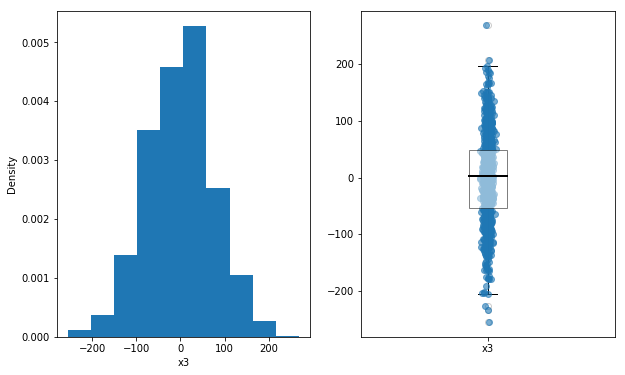

In [76]:
eda_for_numeric("x3", data)

Now...it's tempting to do EDA on $d_2$ and $d_5$ but remember, we don't know that they exist! Let's look at $y$:

count    1.000000e+03
mean     5.495148e+10
std      1.042745e+12
min     -1.268415e+13
25%     -2.608648e+09
50%      9.178397e+03
75%      9.637071e+09
max      1.585154e+13
Name: y, dtype: float64


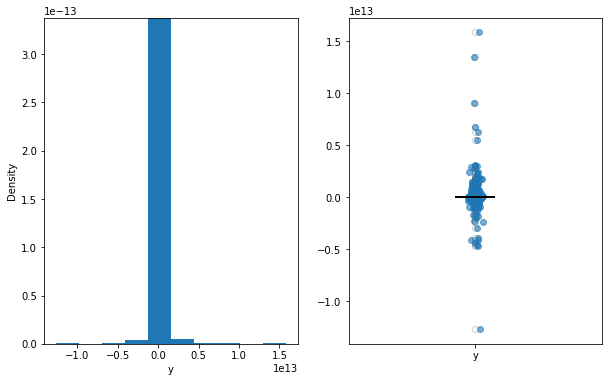

In [77]:
eda_for_numeric( "y", data)

So $y$ is *huge*, how do we figure out what we're missing? What about the pairwise relationships?

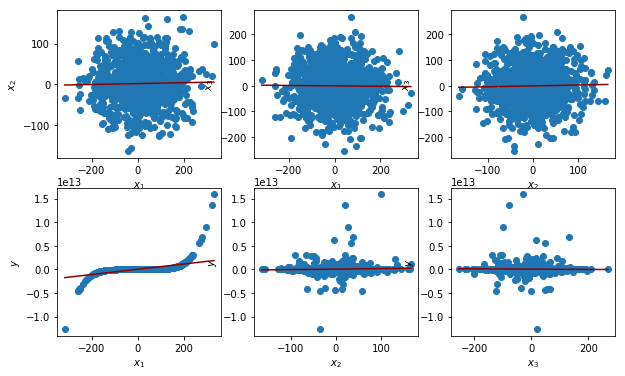

In [78]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(2, 3, 1)
axes.scatter( data[ "x1"], data["x2"])
axes.set_ylabel( "Density")
axes.set_xlabel( r"$x_1$")
axes.set_ylabel( r"$x_2$")
m, b = np.polyfit(data["x1"], data["x2"], 1)
xs = np.linspace(np.min(data["x1"]), np.max(data["x1"]), 100)
axes.plot(xs, m*xs + b, color="darkred")

axes = figure.add_subplot(2, 3, 2)
axes.scatter( data[ "x1"], data["x3"])
axes.set_ylabel( "Density")
axes.set_xlabel( r"$x_1$")
axes.set_ylabel( r"$x_3$")
m, b = np.polyfit(data["x1"], data["x3"], 1)
xs = np.linspace(np.min(data["x1"]), np.max(data["x1"]), 100)
axes.plot(xs, m*xs + b, color="darkred")

axes = figure.add_subplot(2, 3, 3)
axes.scatter( data[ "x2"], data["x3"])
axes.set_ylabel( "Density")
axes.set_xlabel( r"$x_2$")
axes.set_ylabel( r"$x_3$")
m, b = np.polyfit(data["x2"], data["x3"], 1)
xs = np.linspace(np.min(data["x2"]), np.max(data["x2"]), 100)
axes.plot(xs, m*xs + b, color="darkred")

axes = figure.add_subplot(2, 3, 4)
axes.scatter( data[ "x1"], data["y"])
axes.set_ylabel( "Density")
axes.set_xlabel( r"$x_1$")
axes.set_ylabel( r"$y$")
m, b = np.polyfit(data["x1"], data["y"], 1)
xs = np.linspace(np.min(data["x1"]), np.max(data["x1"]), 100)
axes.plot(xs, m*xs + b, color="darkred")

axes = figure.add_subplot(2, 3, 5)
axes.scatter( data[ "x2"], data["y"])
axes.set_ylabel( "Density")
axes.set_xlabel( r"$x_2$")
axes.set_ylabel( r"$y$")
m, b = np.polyfit(data["x2"], data["y"], 1)
xs = np.linspace(np.min(data["x2"]), np.max(data["x2"]), 100)
axes.plot(xs, m*xs + b, color="darkred")

axes = figure.add_subplot(2, 3, 6)
axes.scatter( data[ "x3"], data["y"])
axes.set_ylabel( "Density")
axes.set_xlabel( r"$x_3$")
axes.set_ylabel( r"$y$")
m, b = np.polyfit(data["x3"], data["y"], 1)
xs = np.linspace(np.min(data["x3"]), np.max(data["x3"]), 100)
axes.plot(xs, m*xs + b, color="darkred")


plt.show()
plt.close()

None of the $x_i$ are correlated with each other that we can see. $x_1$ and $y$ have a very interesting relationship. At the relative scales of the $x_i$ and $y$, it's actually hard to see the relationships. We could mean scale everything but let's look at the correlation coefficients first:

In [79]:
print( "x1 v y")
print( "pearsons=", stats.pearsonr( data["x1"], data["y"])[0])
print( "spearman=", stats.spearmanr( data["x1"], data["y"])[0])
print( "-----")
print( "x2 v y")
print( "pearsons=", stats.pearsonr( data["x2"], data["y"])[0])
print( "spearman=", stats.spearmanr( data["x2"], data["y"])[0])
print( "-----")
print( "x3 v y")
print( "pearsons=", stats.pearsonr( data["x3"], data["y"])[0])
print( "spearman=", stats.spearmanr( data["x3"], data["y"])[0])

x1 v y
pearsons= 0.533995105562
spearman= 0.999992247992
-----
x2 v y
pearsons= 0.0525929548146
spearman= 0.0118228078228
-----
x3 v y
pearsons= -0.0234777145309
spearman= -0.00997166197166


This confirms what we can see and some things we can't see. The Pearson's (linear) relationship between $x_1$ and $y$ is very weak but the Spearman's (non-linear) relationship is really strong. Additionally, the relationship between $y$ and the other $x$s isn't very good (why? They were in the model weren't they? Yes but their effects are tiny compared to $d_3$).

One way to confirm what we see would be to look at residuals. We're going to go straight to validation curves, though. We have sufficient evidence that a non-linear relationship exists between $y$ and $x_1$, we can use validation curves to lead us to the right one(s).

Although we used 10 fold cross validation for the learning curves, we're going to follow the notebook and use a resampling approach for the validation curves. However, we want to change it somewhat so we can have the confidence bounds we had for the learning curves (I'm going to change the code but as you see later, I'm not going to use them...the errors are HUGE and make the chart unreadable). The function in the notebook is also badly named: it should be `test_train_split`. This way you can see one of the other approaches:

In [80]:
from copy import deepcopy

def test_train_split( algorithm, formula, data, evaluate, test_size=0.20):
    training_mses = []
    test_mses = []
    
    n = data.shape[ 0]
    test_n = int( np.round( test_size * n, 0))

    indices = list( range(0, len( data)))
    random.shuffle( indices)
    test_indices = indices[ 0:test_n]
    training_indices = indices[test_n:]

    test_set = data.iloc[ test_indices]
    training_set = data.iloc[ training_indices]

    result = algorithm( formula, training_set)
    model = result["model"]
    y, X = patsy.dmatrices( formula, training_set, return_type="matrix")
#    model = linear.LinearRegression( fit_intercept=False).fit( X, y)
    y_hat = model.predict( X)
    training_mse = evaluate( y, y_hat)

    y, X = patsy.dmatrices( formula, test_set, return_type="matrix")
    y_hat = model.predict( X)
    test_mse = evaluate( y, y_hat)

    return training_mse, test_mse

def validation_curves( algorithm, formulas, data, evaluate, iterations=100, test_size=0.2):
    train = []
    test = []
    for formula in formulas:
        train_chunk = []
        test_chunk = []
        for i in range( iterations):
            train_mse, test_mse = test_train_split( algorithm, formula, data, mse, test_size=test_size)
            train_chunk.append( train_mse)
            test_chunk.append( test_mse)
        train.append((np.mean( train_chunk), np.std( train_chunk)))
        test.append((np.mean( test_chunk), np.std( test_chunk)))
    return train, test
#

In [81]:
data["d3"] = x1**3
data["d4"] = x1**4
data["d6"] = x1**6
data["d7"] = x1**7
formulas = ["y ~ x1", "y ~ d2", "y ~ d3", "y ~ d4", "y ~ d5", "y ~ d6", "y ~ d7"]

In [82]:
train, test = validation_curves( regression.lm, formulas, data, mse, 30, 0.1)

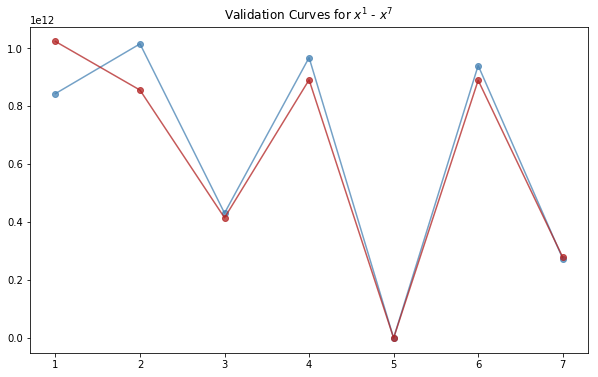

In [83]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
xs = [1, 2, 3, 4, 5, 6, 7]
axes.plot( xs, [t[0] for t in train], 'o-', color="steelblue", alpha=0.75)
axes.plot( xs, [t[0] for t in test], "o-", color="firebrick", alpha=0.75)

axes.set_title( "Validation Curves for $x^1$ - $x^7$")

And so we find our first polynomial term. Should we stop there? This is probably where looking at residuals might come in handy. Although it is usually associated with regression, there's no reason why you shouldn't look at your errors to see if there's a pattern.

Instead, I'm going to see if a lower order term is useful:

In [84]:
formulas = ["y ~ d5 + x1", "y ~ d5 + d2", "y ~ d5 + d3", "y ~ d5 + d4"]

In [85]:
train, test = validation_curves( regression.lm, formulas, data, mse, 30, 0.1)

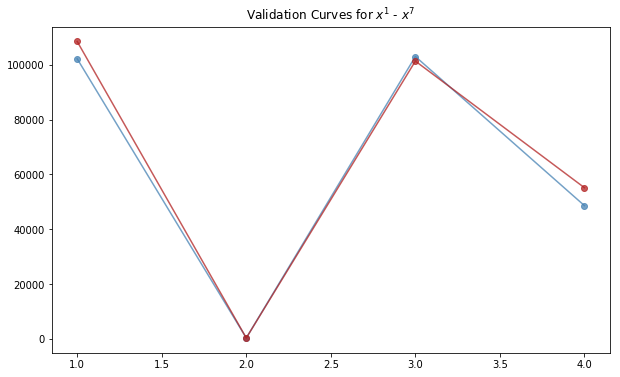

In [86]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
xs = [1, 2, 3, 4]
axes.plot( xs, [t[0] for t in train], 'o-', color="steelblue", alpha=0.75)
axes.plot( xs, [t[0] for t in test], "o-", color="firebrick", alpha=0.75)

axes.set_title( "Validation Curves for $x^1$ - $x^7$")

Boom! $x_1^2$ pops right out. (I'm *still* looking for the error in the Notebook!).

At this point, we would probably switch back to learning curves and see if we couldn't discover that $x_2$ and $x_3$ had at least *some* part to play.